In [1]:
# import os, sys
# path= '/Users/sbielfel/Nextcloud2/time_resolved/'
# path= '/Users/sbielfel/Nextcloud2/phase_retrieval/algos'
# sys.path.append(path)
# from helpers import make_input


In [2]:
from occupancy import *


In [3]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

# Note: this is the same notebook occupancy basic
The only "active" change is Gaussian noise with $\sigma=\langle|F_{0}|\rangle$. Since the fork I have tweaked `occupancy-basic` a bit. For now, text is minimal.

This notebook exists to show how the plots change in the face of Gaussian noise. Below there is still a bit of stuff I want to use later.

# Data Preparation

In [4]:
alpha = 0.3
noise_level = 1
obj1, obj0 =  make_objs(blur_by=2) # previous image 
obj1, obj0 =  make_objs(n_pos=50,blur_by=5, delta_x=-7, delta_y=7, seed=4) # simpler image
vmax = np.max(obj0)
# obj1, obj0 = obj1/vmax, obj0/vmax
f_dark, f_light, delta_fa_abs = make_working_vars(obj1, obj0, alpha, old_version=False)
# make_working_vars(obj1, obj0, alpha, old_version=True) 


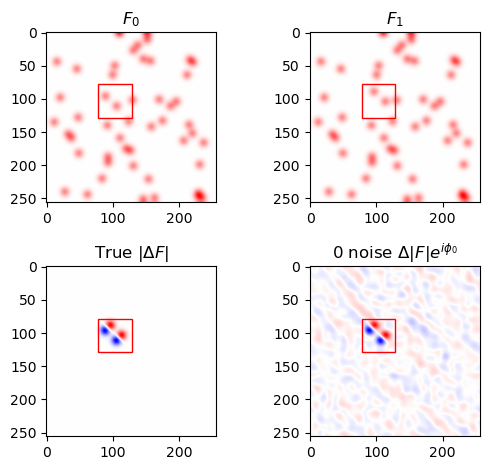

In [5]:
from matplotlib import patches 
fig, axsi = plt.subplots(2,2, tight_layout=True)
axs = axsi.flat
img_mid = 128
boxleng = -50

obj_diff = obj1-obj0
f_diff = np.fft.fftn(obj_diff)
obj_diff_conj = np.fft.ifftn(np.conj(f_diff)* np.exp(2j*np.angle(f_dark))).real
obj_diff_comb = (obj_diff + obj_diff_conj)/2


for ax in axs:
    rect = patches.Rectangle((img_mid, img_mid), boxleng, boxleng, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    
ax = axs[0]
ax.set_title(r"$F_0$")
ax.imshow(obj0, cmap= "bwr", vmin=-np.max(obj0))
ax = axs[1]
ax.set_title(r"$F_1$")
ax.imshow(obj1, cmap= "bwr", vmin = -np.max(obj0))

ax = axs[2]
ax.set_title(r"True $|\Delta F|$")
ax.imshow(obj_diff, cmap = "bwr", )

ax = axs[3]
ax.set_title(r"0 noise $\Delta |F|e^{i\phi_0}$")
ax.imshow(obj_diff_comb, cmap = "bwr",)


In [6]:
iso_diff_test = np.sum(np.abs(f_diff)) / np.sum(np.abs(f_dark))
print(f"Test whether F_Diff/F_0 ratio {iso_diff_test:.2f} < 0.25")

Test whether F_Diff/F_0 ratio 0.18 < 0.25


Calculate $F_{xtr}$ as 
$$ 
F_{xtr} = 2/\alpha_{xtr}*\Delta |F| e^{i\phi_0}+F_0
$$

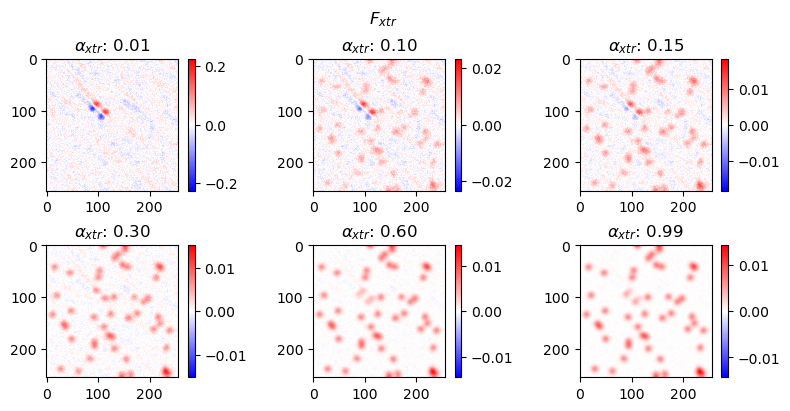

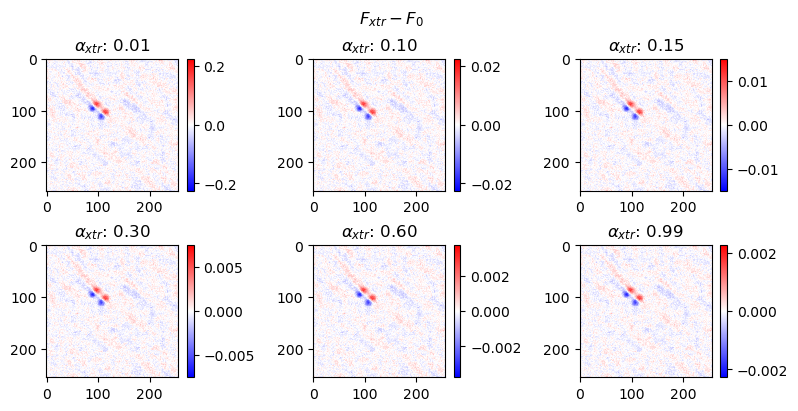

In [7]:
alpha_xtrs_vis = np.array([0.01, 0.1, alpha/2, alpha, 2*alpha, .99])
f_xtrs_vis = make_f_xtr(alpha_xtrs_vis, f_dark, f_light, np.angle(f_dark),  version=1, noise_level = noise_level)
dens_xtrs_vis, _ = marius(f_xtrs_vis)
# dens_xtrs_vis = np.fft.fftn(f_xtrs_vis, axes=np.arange(1,f_xtrs_vis.ndim)).real
fig1, axs1 = plt.subplots(2,3, figsize=(8,4),constrained_layout=True)
fig2, axs2 = plt.subplots(2,3, figsize=(8,4),constrained_layout=True)
steps = 1
for ax1,ax2, alpha_xtr, arr in zip(axs1.flat,axs2.flat, alpha_xtrs_vis,dens_xtrs_vis):
    rect = patches.Rectangle((img_mid, img_mid), boxleng, boxleng, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    raw = [r"$\alpha_{xtr}$",
           r"$\alpha_t$"]
    tit = f"{raw[0]}: {alpha_xtr:.2f}"
    ax1.set_title(tit)
    ax2.set_title(tit)
    vmax = np.max(arr)
    im = ax1.imshow(arr, cmap="bwr",vmin=-vmax, vmax=vmax)
    plt.colorbar(im)
    
    diff = (arr-obj0)
    vmax = np.max(diff)
    im = ax2.imshow(diff, cmap="bwr",vmin=-vmax, vmax=vmax)
    plt.colorbar(im)
    
fig1.suptitle("$F_{xtr}$")
fig2.suptitle("$F_{xtr} - F_0$")

plt.show()    


$F_0$ does not contain noise, so noise is only visible for lower occupancies.
$F_{xtr}-F_0$ is, as before, immune to influences.

50.0 [61.25206544]
[0.816299]



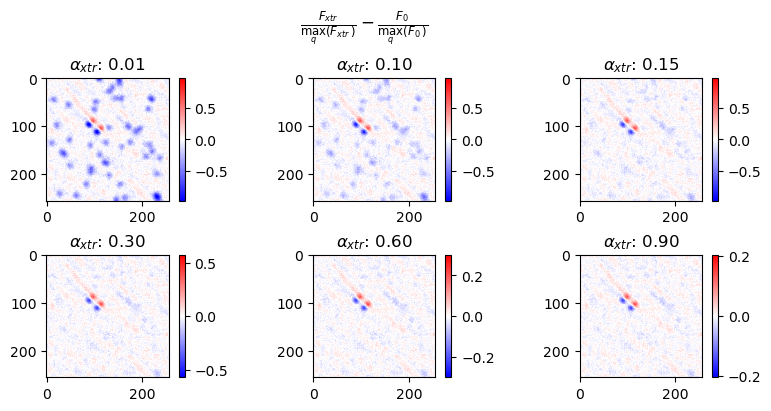

In [8]:
# make_working_vars(obj1, obj0, alpha, old_version=True) 

alpha_xtrs_vis = np.array([0.01, 0.1, alpha/2, alpha, 2*alpha, .9])
f_xtrs_vis = make_f_xtr(alpha_xtrs_vis, f_dark, f_light, np.angle(f_dark),  version=1, noise_level = noise_level)
dens_xtrs_vis, _ = marius(f_xtrs_vis)
# dens_xtrs_vis = np.fft.fftn(f_xtrs_vis, axes=np.arange(1,f_xtrs_vis.ndim)).real
fig, axs = plt.subplots(2,3, figsize=(8,4),constrained_layout=True)
steps = 1
print( np.sum(obj0.flatten()), np.sum(np.abs(dens_xtrs_vis[5])).flatten())
print( np.sum(obj0.flatten())/ np.sum(np.abs(dens_xtrs_vis[5])).flatten())
print()

for ax, alpha_xtr, arr in zip(axs.flat, alpha_xtrs_vis,dens_xtrs_vis):
    
    raw = [r"$\alpha_{xtr}$",
           r"$\alpha_t$"]
    tit = f"{raw[0]}: {alpha_xtr:.2f}"
    ax.set_title(tit)
    diff = arr/np.max(arr)-obj0/np.max(obj0)
    vmax = np.max(diff)
    im = ax.imshow(diff, cmap="bwr",vmin=-vmax, vmax=vmax)
    plt.colorbar(im)
plt.suptitle(r"$\frac{F_{xtr}}{\max_q(F_{xtr})} - \frac{F_0}{\max_q(F_0)}$")
plt.show()    

I would have expected the effect of noise to be larger. That we would see more than just a loss of the mean value for larger assumed occupancies. But we have the same picture as in the noise free case, just with high frequency noise.

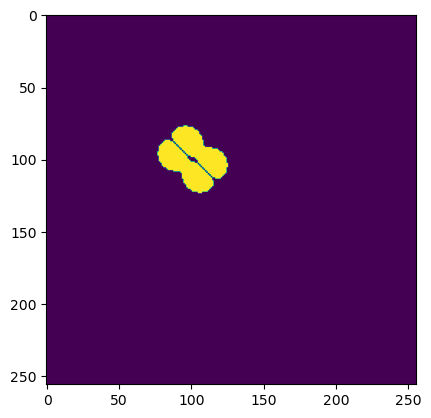

In [9]:
delta_obj = alpha*(obj1-obj0)
mask_pks = np.abs(delta_obj)>0.0001
fig, axs = plt.subplots(1,1)
# ax = axs[0]
axs.imshow(mask_pks)
# ax = axs[1]
# ax.imshow(mask_pks)

In [10]:
from occupancy import  x8_density_map_fdiff_norm
f_mix = np.fft.fft2(delta_obj)
true_phase = np.angle(f_mix)
rand_phase = np.random.uniform(size=true_phase.shape)*2*np.pi

alpha_xtrs = np.linspace(5e-2,1,150 )

f_xtrs = make_f_xtr(alpha_xtrs, f_dark, f_light, np.angle(f_dark),  version=1, noise_level=noise_level)
peak_sum, real_CC = x8_density_map_f1(f_xtrs, mask_pks, obj0, delta_obj)
peak_sum_diff, real_CC_diff = x8_density_map_fdiff(f_xtrs, mask_pks, obj0, delta_obj)
peak_sum_diffnorm, real_CC_diffnorm = x8_density_map_fdiff_norm(f_xtrs, mask_pks, obj0, delta_obj)

#print(np.max(),axis=(1,2)))
pk_val = alpha_xtrs[np.argmax(peak_sum_diffnorm)]
pk_val


0.13926174496644295

In [11]:
noise_level=1

Text(0.5, 0, 'occupancy')

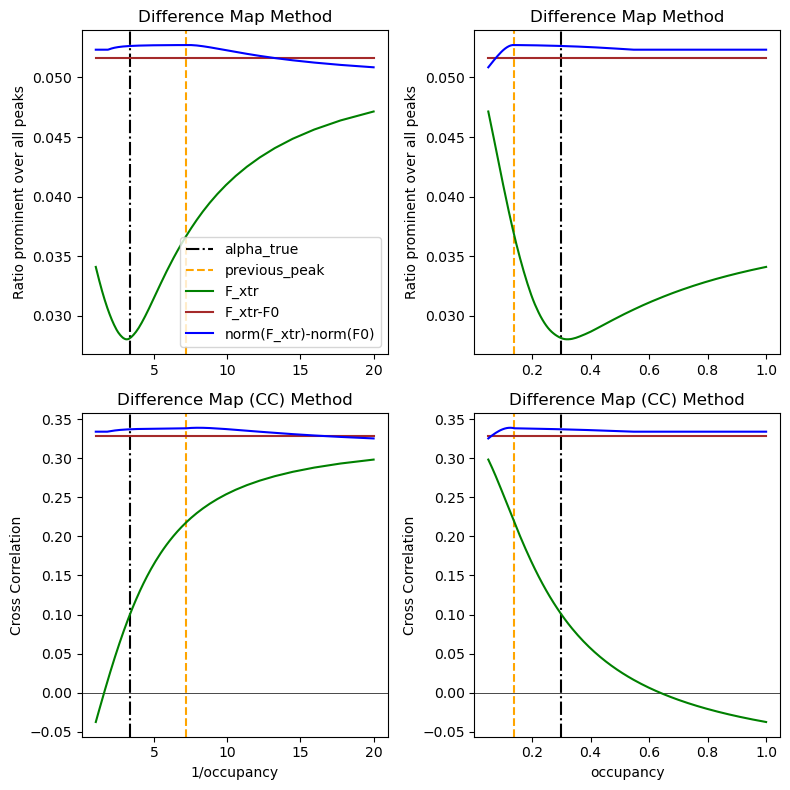

In [12]:
fig, axs = plt.subplots(2,2, figsize=(8,8),tight_layout=True)
for ax in axs[0] :
    ax.set_ylabel("Ratio prominent over all peaks")
    ax.set_title("Difference Map Method")
    
for ax in axs[:,0] :
    ax.axvline(1/alpha,c="k", linestyle="-.", label="alpha_true")
    ax.axvline(1/pk_val,c="orange", linestyle="--", label="previous_peak")
    
for ax in axs[:,1] :
    ax.axvline(alpha,c="k", linestyle="-.", label="alpha_true")
    ax.axvline(pk_val,c="orange", linestyle="--", )
    # ax.set_xlim(0,0.5)
    
for ax in axs[1] :
    ax.axhline(0,c="k", linewidth=.5, )
    ax.set_ylabel("Cross Correlation")
    ax.set_xlabel("Alphas")
    ax.set_title("Difference Map (CC) Method")

ax = axs[0,0]
ax.plot(1/alpha_xtrs,peak_sum, label=r"F_xtr",color="g")
ax.plot(1/alpha_xtrs,peak_sum_diff, label=r"F_xtr-F0",color="brown")
ax.plot(1/alpha_xtrs,peak_sum_diffnorm, label=r"norm(F_xtr)-norm(F0)",color="b")
ax.legend()

ax = axs[0,1]
ax.plot(alpha_xtrs,peak_sum, label=r"$\phi_{0}$",color="g")
ax.plot(alpha_xtrs,peak_sum_diff, label=r"$\phi_{0}$",color="brown")
ax.plot(alpha_xtrs,peak_sum_diffnorm, label=r"norm(F_xtr)-norm(F0)",color="b")

ax = axs[1,0]
ax.plot(1/alpha_xtrs,real_CC, label=r"$\phi_{0}$",color="g")
ax.plot(1/alpha_xtrs,real_CC_diff, label=r"F_xtr-F0",color="brown")
ax.plot(1/alpha_xtrs,real_CC_diffnorm, label=r"norm: F_xtr-F0",color="b")
ax.set_xlabel("1/occupancy")

ax = axs[1,1]
ax.plot(alpha_xtrs,real_CC,  label=r"F_xtr"    ,    color="g")
ax.plot(alpha_xtrs,real_CC_diff, label=r"F_xtr-F0",color="brown")
ax.plot(alpha_xtrs,real_CC_diffnorm, label=r"norm: F_xtr-F0",color="b")
ax.set_xlabel("occupancy")


-130099.31062882901


Text(0, 0.5, 'Full view')

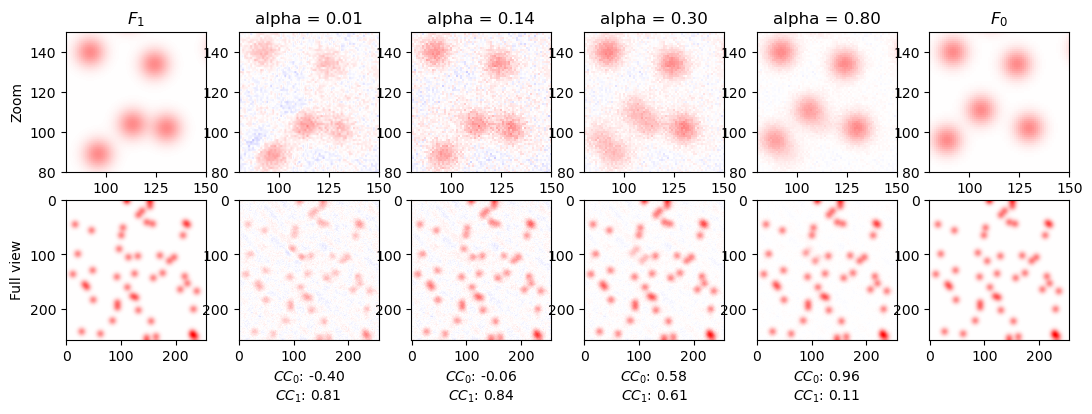

In [13]:
noise = np.random.normal(size=f_dark.shape) * np.mean(np.abs(f_dark)) * noise_level
delta_f = np.abs(f_light) - np.abs(f_dark) + noise
delta_f_with_phase = delta_f * np.exp(1j * np.angle(f_dark))

f_proposed = 2/pk_val*(delta_f_with_phase)+f_dark
rho_proposed = np.fft.ifft2(f_proposed).real
rho_prop_ = (rho_proposed/np.max(rho_proposed,axis=0) + obj0/np.max(obj0))/2

alpha_chosen = np.array([0.01, pk_val, alpha, 0.8])
f_prop = make_f_xtr(np.array(alpha_chosen), f_dark, f_light, np.angle(f_dark),  version=1, noise_level=noise_level)
rho_prop = np.fft.ifft2(f_prop).real
rho_prop = rho_prop/np.max(rho_prop,axis=0) #+ obj0/np.max(obj0))/2
# rho_prop = + obj0/np.max(obj0)
# props = [obj0, obj1
tit = [f"alpha = {aa:.2f}" for aa in alpha_chosen]
titles =  ["$F_1$", *tit, "$F_0$",]
lims = (80,150)
print(np.min(rho_prop))
fig, axso = plt.subplots(2,6, figsize=(13,4))
rho_proposed_list = []
for axs in axso:
    ax= axs[0]
    ax.imshow(obj1/np.max(obj1), cmap="bwr", vmin=-1,vmax=1)
    for ii,ax in enumerate(axs[1:-1]):

        f_proposed = 2/alpha_chosen[ii]*(delta_f_with_phase)+f_dark
        rho_proposed = np.fft.ifft2(f_proposed).real
        rho_proposed = (rho_proposed/np.max(rho_proposed) + obj0/np.max(obj0))/2
        rho_proposed_list.append(rho_proposed)

        ax.imshow(rho_proposed, cmap="bwr", vmin=-1,vmax=1)
    ax= axs[-1]
    ax.imshow(obj0/np.max(obj0), cmap="bwr", vmin=-1,vmax=1)
for ii,ax in enumerate( axso[0]):
    ax.set_title(titles[ii])
    ax.set_xlim(*lims)
    ax.set_ylim(*lims)
for ii,ax in enumerate( axso[1,1:-1]):
    
    cc0 = pearsonr(rho_proposed_list[ii].flatten(), obj0.flatten())[0]
    cc1 = pearsonr(rho_proposed_list[ii].flatten(), obj1.flatten())[0]
    
    cc0 = pearsonr(rho_proposed_list[ii][mask_pks], obj0[mask_pks])[0]
    cc1 = pearsonr(rho_proposed_list[ii][mask_pks], obj1[mask_pks])[0]
    ax.set_xlabel(f"$CC_0$: {cc0:.2f}\n$CC_1$: {cc1:.2f}")

axso[0,0].set_ylabel("Zoom")
axso[1,0].set_ylabel("Full view")


In [14]:
alpha_invs = (np.arange(0,20)+1e-10)
alpha_xtrs = 1/alpha_invs
from occupancy import marius
f_xtrs = make_f_xtr(alpha_xtrs, f_dark, f_light, np.angle(f_dark),  version=1, noise_level = noise_level)
dens_xtrs, neg_sum = marius(f_xtrs)

Text(0, 0.5, '$\\sum$ |extrapolated neg. density|')

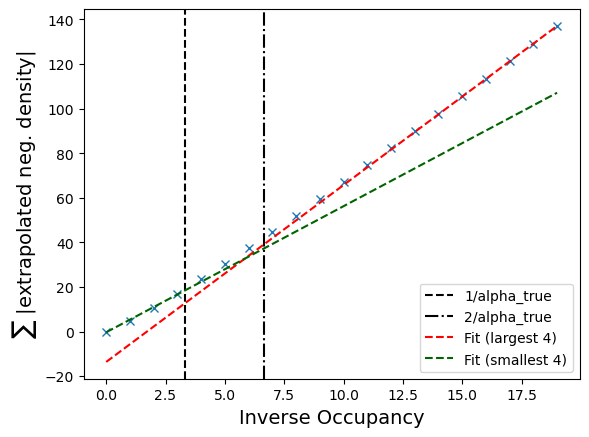

In [15]:
from scipy import stats
n_largest = 4
m1 = alpha_invs>alpha_invs[-n_largest]
m2 = alpha_invs<alpha_invs[n_largest]
res_1 = stats.linregress(alpha_invs[m1], -neg_sum[m1])
res_2 = stats.linregress(alpha_invs[m2], -neg_sum[m2])
# res_11 = stats.linregress(alpha_invs[m11], -neg_sum[m11])
# res_22 = stats.linregress(alpha_invs[m22], -neg_sum[m22])

alpha_line = np.linspace(np.min(alpha_invs), np.max(alpha_invs),5,)

plt.plot(alpha_invs,neg_sum*-1, "x" )
plt.axvline(1/alpha,c="k",linestyle="--", label="1/alpha_true")
plt.axvline(2/alpha,c="k",linestyle="-.", label="2/alpha_true")


plt.plot(alpha_line, res_1.intercept+res_1.slope*alpha_line,c="red",linestyle="--", label=f"Fit (largest {n_largest})")
plt.plot(alpha_line, res_2.intercept+res_2.slope*alpha_line, c="darkgreen",linestyle="--",label=f"Fit (smallest {n_largest})")
# plt.plot(alpha_line, res_11.intercept+res_11.slope*alpha_line,c="purple",linestyle="--", label="Fit (all larger )")
plt.legend()
# plt.plot(alpha_line, res_22.intercept+res_22.slope*alpha_line, c="purple",linestyle="--")
# plt.ylim(20,40)
fs = 14
plt.xlabel("Inverse Occupancy", fontsize = fs)
plt.ylabel(r"$\sum$ |extrapolated neg. density|", fontsize=fs)
# plt.title("'Marius Method'")
# plt.savefig("mariusmethod.png")

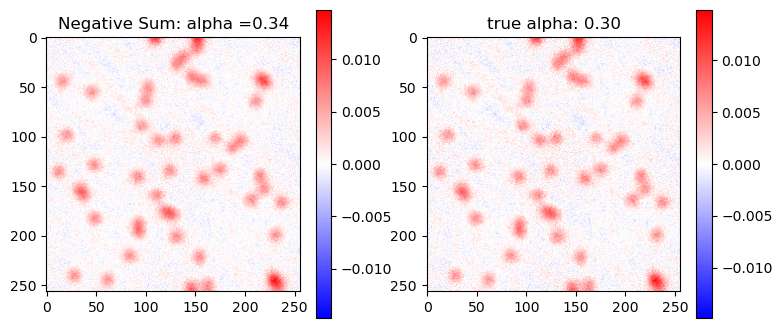

In [16]:
def compare_output(alpha_chosen, titles, noise_level=0):
    f_prop = make_f_xtr(np.array(alpha_chosen), f_dark, f_light, np.angle(f_dark),  version=1, noise_level=noise_level)
    rho_proposed = np.fft.ifft2(f_prop).real
    fig, axs = plt.subplots(1,len(titles), figsize=(len(titles)*4+1,4))
    for ii, rho_prop in enumerate(rho_proposed):
        vmax = np.max(rho_prop)
        ax = axs[ii]
        im = ax.imshow(rho_prop, cmap="bwr", vmin=-vmax, vmax=vmax)
        ax.set_title(titles[ii])
        plt.colorbar(im)
        
intersection = (res_2.intercept-res_1.intercept) / (res_1.slope-res_2.slope)
alpha_intersect = 2/intersection

alpha_chosen = [alpha_intersect, alpha]
titles=[r'Negative Sum: alpha ='+ f'{alpha_intersect:.2f}', f'true alpha: {alpha:.2f}']
compare_output(alpha_chosen, titles, noise_level=1)


# PanDDA Method

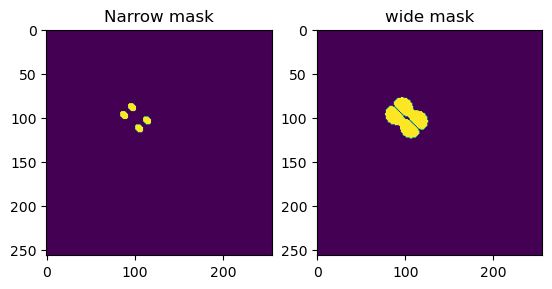

In [17]:
delta_obj = alpha*(obj1-obj0)
mask_pks_strict = np.abs(delta_obj)>0.001
mask_pks_lax = np.abs(delta_obj)>0.0001
fig, axs = plt.subplots(1,2)
ax = axs[0]
ax.set_title("Narrow mask")
ax.imshow(mask_pks_strict)
ax = axs[1]
ax.set_title("wide mask")
ax.imshow(mask_pks_lax)
# ax = axs[1]
# ax.imshow(mask_pks)


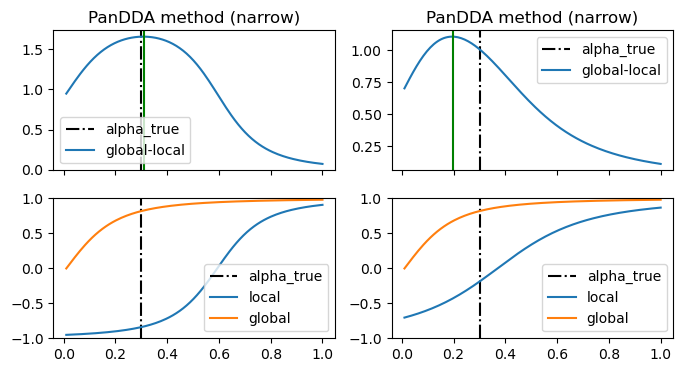

In [18]:
alpha_xtrs = np.linspace(1e-2,1,150 )
f_xtrs = make_f_xtr(alpha_xtrs, f_dark, f_light, np.angle(f_dark),  version=1, noise_level=noise_level)
mean_local_strict, mean_global_strict = pandda(f_dark, f_xtrs, mask_pks_strict)
mean_local_lax, mean_global_lax = pandda(f_dark, f_xtrs, mask_pks_lax)

mean_local, mean_global =  mean_local_strict, mean_global_strict
# mean_local, mean_global =  mean_local_lax, mean_global_lax
ml = [mean_local_strict, mean_local_lax]
mg = [mean_global_strict, mean_global_lax]
titles = ["narrow mask", "wide mask"]

fig, axso = plt.subplots(2,2, figsize =(8,4), sharex=True)
for axs, mean_local, mean_global, title in zip(axso.T, ml, mg, titles):

# fig, axs = plt.subplots(3, )
    ax = axs[0]
    ax.axvline(alpha,c="k", linestyle="-.", label="alpha_true")
    ax.plot(alpha_xtrs,+mean_global-mean_local, label="global-local") 
    pk_val_narrow = alpha_xtrs[np.argmax(mean_global-mean_local)]
    ax.axvline(pk_val_narrow, color="green")
    md = mean_global-mean_local
    # print(md[md>=1.8])
    # ax.set_ylim(1., 1.9)
    ax.legend()
    ax.set_title("PanDDA method (narrow)")
    ax = axs[1]
    ax.axvline(alpha,c="k", linestyle="-.", label="alpha_true")
    ax.plot(alpha_xtrs,mean_local, label="local") 
    ax.plot(alpha_xtrs, mean_global,label="global")
    ax.set_ylim(-1,1)
    ax.legend()


What I found was that the PanDDA method is very dependent on what exactly is flagged as the region of interest. So for the narrow selection, I 

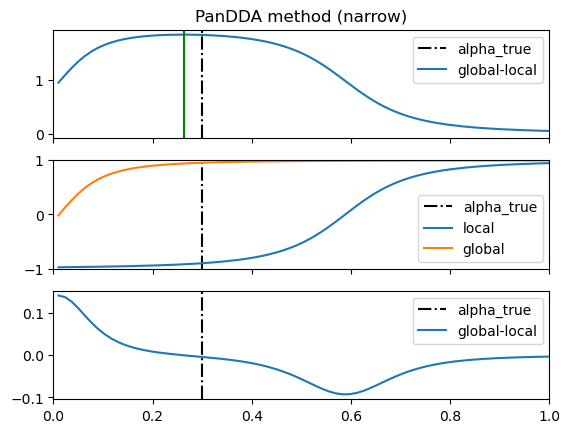

In [19]:
alpha_xtrs = np.linspace(1e-2,2,150 )
f_xtrs = make_f_xtr(alpha_xtrs, f_dark, f_light, np.angle(f_dark),  version=1, noise_level=0)
mean_local, mean_global = pandda(f_dark, f_xtrs, mask_pks_strict)
fig, axs = plt.subplots(3, sharex=True)
ax = axs[0]
ax.axvline(alpha,c="k", linestyle="-.", label="alpha_true")
ax.plot(alpha_xtrs,+mean_global-mean_local, label="global-local") 
pk_val_narrow = alpha_xtrs[np.argmax(mean_global-mean_local)]
ax.axvline(pk_val_narrow, color="green")
md = mean_global-mean_local
# print(md[md>=1.8])
# ax.set_ylim(1., 1.9)
ax.legend()
ax.set_title("PanDDA method (narrow)")
ax = axs[1]
ax.axvline(alpha,c="k", linestyle="-.", label="alpha_true")
ax.plot(alpha_xtrs,mean_local, label="local") 
ax.plot(alpha_xtrs, mean_global,label="global")
ax.set_ylim(-1,1)
ax.legend()
ax = axs[2]
ax.axvline(alpha,c="k", linestyle="-.", label="alpha_true")
ax.plot(alpha_xtrs,+np.gradient(mean_global-mean_local), label="global-local")
ax.set_xlim(0,1)
ax.legend()


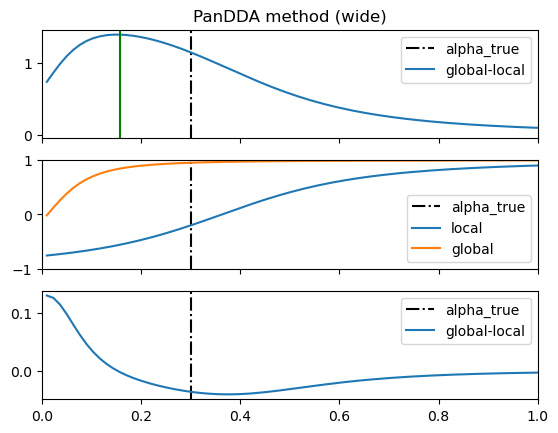

In [20]:
alpha_xtrs = np.linspace(1e-2,2,150 )
f_xtrs = make_f_xtr(alpha_xtrs, f_dark, f_light, np.angle(f_dark),  version=1, noise_level=0)
mean_local, mean_global = pandda(f_dark, f_xtrs, mask_pks_lax)
fig, axs = plt.subplots(3, sharex=True)
ax = axs[0]
ax.axvline(alpha,c="k", linestyle="-.", label="alpha_true")
ax.plot(alpha_xtrs,+mean_global-mean_local, label="global-local") 
pk_val_wide = alpha_xtrs[np.argmax(mean_global-mean_local)]
ax.axvline(pk_val_wide, color="green")
ax.legend()
ax.set_title("PanDDA method (wide)")
ax = axs[1]
ax.axvline(alpha,c="k", linestyle="-.", label="alpha_true")
ax.plot(alpha_xtrs,mean_local, label="local") 
ax.plot(alpha_xtrs, mean_global,label="global")
ax.set_ylim(-1,1)
ax.legend()
ax = axs[2]
ax.axvline(alpha,c="k", linestyle="-.", label="alpha_true")
ax.plot(alpha_xtrs,+np.gradient(mean_global-mean_local), label="global-local") 
ax.set_xlim(0,1)
ax.legend()



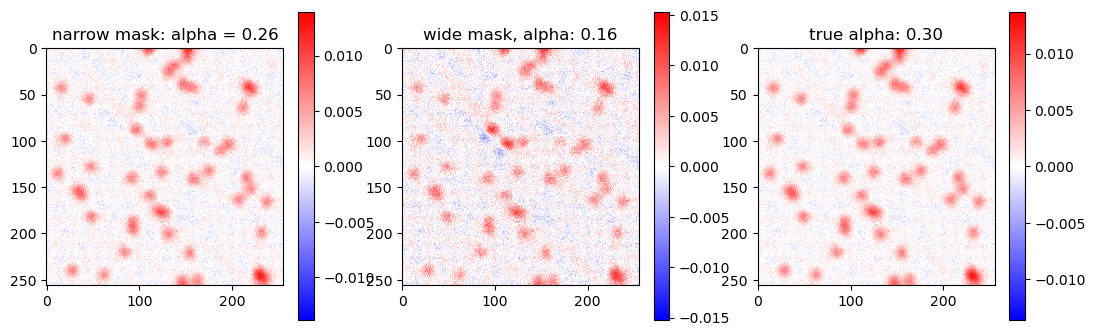

In [21]:

alpha_chosen = [pk_val_narrow, pk_val_wide, alpha]
titles=[f'narrow mask: alpha = {pk_val_narrow:.2f}', f'wide mask, alpha: {pk_val_wide:.2f}', f'true alpha: {alpha:.2f}']
compare_output(alpha_chosen, titles, noise_level=1)


# Stop Reading here

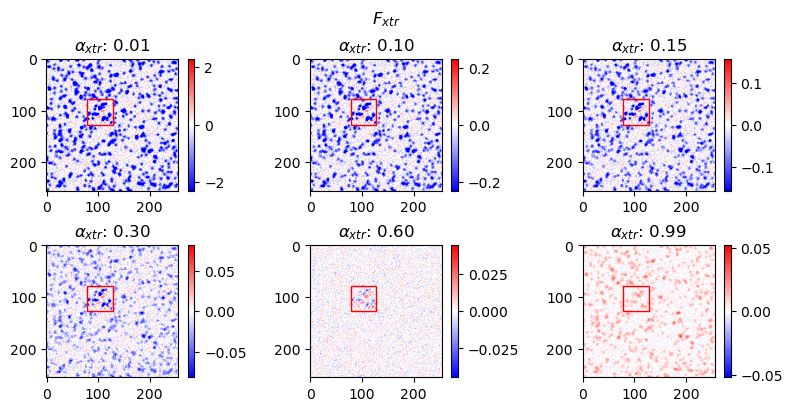

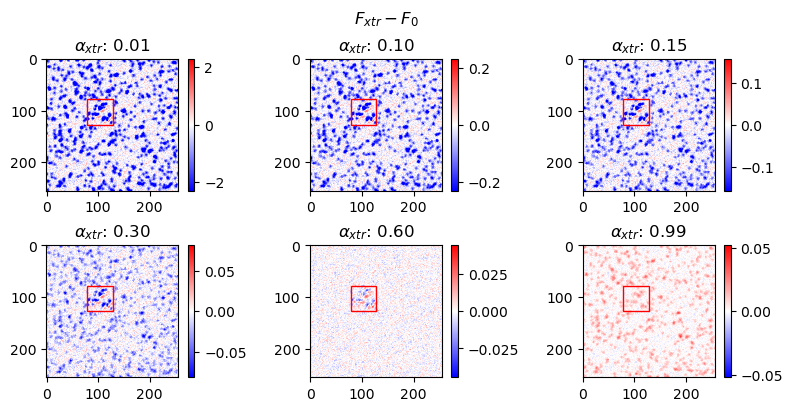

cc_mix=-0.17872011826817266	cc_2alph_comb=0.06159959621552383 cc_2alph_0=0.6630599928958361
596.0000000000001 [426.35190165]
[1.39790628]



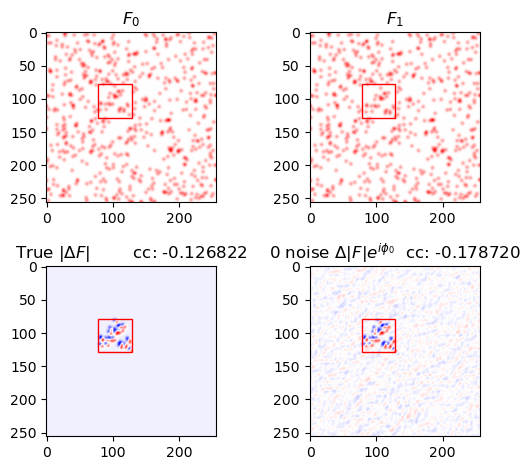

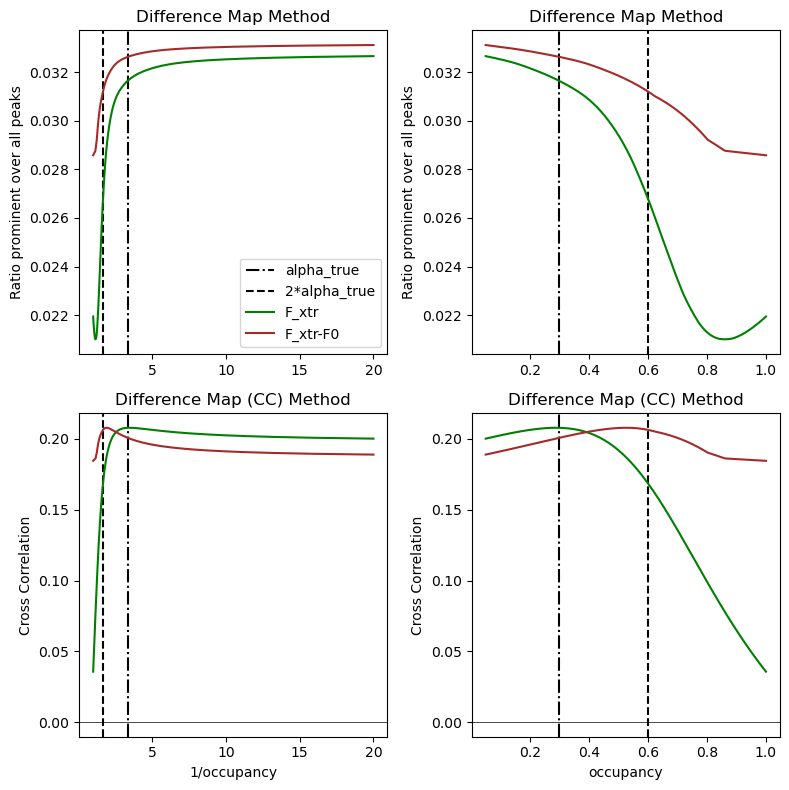

In [22]:
{
    "tags": [
        "hide-input",
    ]
}
# this cell contains the error from my last message
from occupancy import x8_density_map_f1,x8_density_map_fdiff

def self_contained():
    img_mid = 128
    boxleng = -50
    
    obj1, obj0 =  make_objs(blur_by=2) # previous image 
    delta_obj = obj1-obj0
    mask_pks = np.abs(delta_obj)>0.01
    
    delta_obj = alpha*obj1-alpha*obj0
    alpha_xtrs = np.linspace(5e-2,1,150 )
    f_dark, f_light, delta_fa_abs = make_working_vars(obj1, obj0, alpha, old_version=True)

    
    alpha_xtrs_vis = np.array([0.01, 0.1, alpha/2, alpha, 2*alpha, .99])
    # alpha_xtrs = alpha_xtrs_vis
    f_xtrs_vis = make_f_xtr(alpha_xtrs_vis, f_dark, f_light, np.angle(f_dark),  version=1, noise_level = noise_level)
    dens_xtrs_vis, _ = marius(f_xtrs_vis)
    # dens_xtrs_vis = np.fft.fftn(f_xtrs_vis, axes=np.arange(1,f_xtrs_vis.ndim)).real
    fig1, axs1 = plt.subplots(2,3, figsize=(8,4),constrained_layout=True)
    fig2, axs2 = plt.subplots(2,3, figsize=(8,4),constrained_layout=True)
    steps = 1
    for ax1,ax2, alpha_xtr, arr in zip(axs1.flat,axs2.flat, alpha_xtrs_vis,dens_xtrs_vis):
        rect = patches.Rectangle((img_mid, img_mid), boxleng, boxleng, linewidth=1, edgecolor='r', facecolor='none')
        ax1.add_patch(rect)
        rect = patches.Rectangle((img_mid, img_mid), boxleng, boxleng, linewidth=1, edgecolor='r', facecolor='none')
        ax2.add_patch(rect)
        raw = [r"$\alpha_{xtr}$",
               r"$\alpha_t$"]
        tit = f"{raw[0]}: {alpha_xtr:.2f}"
        ax1.set_title(tit)
        ax2.set_title(tit)
        vmax = np.max(arr)
        im = ax1.imshow(arr, cmap="bwr",vmin=-vmax, vmax=vmax)
        plt.colorbar(im)
        prefactor =596 
        diff = (arr-obj0/prefactor)
        vmax = np.max(diff)
        im = ax2.imshow(diff, cmap="bwr",vmin=-vmax, vmax=vmax)
        plt.colorbar(im)

    fig1.suptitle("$F_{xtr}$")
    fig2.suptitle("$F_{xtr} - F_0$")

    plt.show()    
    fig, axsi = plt.subplots(2,2, tight_layout=True)
    axs = axsi.flat

    obj_diff = obj1-obj0
    f_diff = np.fft.fftn(obj_diff)
    obj_diff_conj = np.fft.ifftn(np.conj(f_diff)* np.exp(2j*np.angle(f_dark))).real
    obj_diff_comb = (obj_diff + obj_diff_conj)/2


    for ax in axs:
        rect = patches.Rectangle((img_mid, img_mid), boxleng, boxleng, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    ax = axs[0]
    ax.set_title(r"$F_0$")
    ax.imshow(obj0, cmap= "bwr", vmin=-np.max(obj0))
    ax = axs[1]
    ax.set_title(r"$F_1$")
    ax.imshow(obj1, cmap= "bwr", vmin =-np.max(obj1))

    ax = axs[2]
    cc_true = pearsonr(obj0.flatten(), obj_diff.flatten())[0]
                       
    ax.set_title(r"True $|\Delta F|$"+f"\t cc: {cc_true:2f}")
    ax.imshow(obj_diff, cmap = "bwr", )

    ax = axs[3]
    cc_mix = pearsonr(obj0.flatten(), obj_diff_comb.flatten())[0]
    cc_2alph_comb = pearsonr(dens_xtrs_vis[5].flatten(), obj_diff_comb.flatten())[0]
    # cc_comb_0 = pearsonr(obj0.flatten(), obj_diff_comb.flatten())[0]
    cc_2alph_0 = pearsonr(obj0.flatten(), dens_xtrs_vis[5].flatten())[0]
    print(f"{cc_mix=}\t{cc_2alph_comb=}{ cc_2alph_0=}")
    ax.set_title(r"0 noise $\Delta |F|e^{i\phi_0}$"+f"\t cc: {cc_mix:2f}")
    ax.imshow(obj_diff_comb, cmap = "bwr",)
    print( np.sum(obj0.flatten()), np.sum(np.abs(dens_xtrs_vis[5])).flatten())
    print( np.sum(obj0.flatten())/ np.sum(np.abs(dens_xtrs_vis[5])).flatten())
    print()
    
    f_xtrs = make_f_xtr(alpha_xtrs, f_dark, f_light, np.angle(f_dark),  version=1, noise_level=noise_level)
    peak_sum, real_CC = x8_density_map_f1(f_xtrs, mask_pks, obj0, delta_obj)
    peak_sum4, real_CC4 = x8_density_map_fdiff_norm(f_xtrs, mask_pks, obj0, delta_obj)
    
    
    fig, axs = plt.subplots(2,2, figsize=(8,8),tight_layout=True)
    for ax in axs[0] :
        ax.set_ylabel("Ratio prominent over all peaks")
        ax.set_title("Difference Map Method")

    for ax in axs[:,0] :
        ax.axvline(1/alpha,c="k", linestyle="-.", label="alpha_true")
        ax.axvline(1/(alpha*2),c="k", linestyle="--", label="2*alpha_true")

    for ax in axs[:,1] :
        ax.axvline(alpha,c="k", linestyle="-.", label="alpha_true")
        ax.axvline(alpha*2,c="k", linestyle="--", label="2*alpha_true")

    for ax in axs[1] :
        ax.axhline(0,c="k", linewidth=.5, )
        ax.set_ylabel("Cross Correlation")
        ax.set_xlabel("Alphas")
        ax.set_title("Difference Map (CC) Method")

    ax = axs[0,0]
    ax.plot(1/alpha_xtrs,peak_sum, label=r"F_xtr",color="g")
    ax.plot(1/alpha_xtrs,peak_sum4, label=r"F_xtr-F0",color="brown")
    ax.legend()

    ax = axs[0,1]
    ax.plot(alpha_xtrs,peak_sum, label=r"$\phi_{0}$",color="g")
    ax.plot(alpha_xtrs,peak_sum4, label=r"$\phi_{0}$",color="brown")

    ax = axs[1,0]
    ax.plot(1/alpha_xtrs,real_CC, label=r"$\phi_{0}$",color="g")
    ax.plot(1/alpha_xtrs,real_CC4, label=r"$\phi_{0}$",color="brown")
    ax.set_xlabel("1/occupancy")

    ax = axs[1,1]
    ax.plot(alpha_xtrs,real_CC,  label=r"F_xtr"    ,    color="g")
    ax.plot(alpha_xtrs,real_CC4, label=r"F_xtr-F0",color="brown")
    ax.set_xlabel("occupancy")
self_contained()

In [23]:
alpha_xtrs = np.linspace(0,1,340)+1e-10
f_xtrs = make_f_xtr(alpha_xtrs, f_dark, f_light, np.angle(f_dark),  version=2, noise_level = noise_level)
corr_x8 = x8_inspired(np.abs(f_dark),np.abs(f_light), np.abs(f_xtrs))

Text(0, 0.5, 'Gradient of CC')

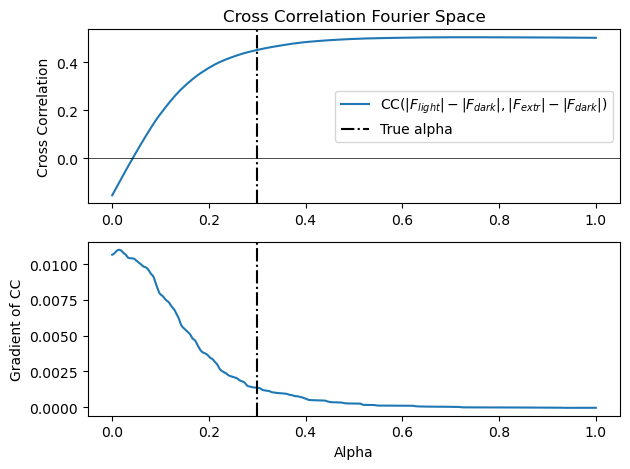

In [24]:
fig, axs = plt.subplots(2, tight_layout=True)
ax = axs[0]
ax.plot(alpha_xtrs,corr_x8, label="CC($|F_{light}|-|F_{dark}|, |F_{extr}| - |F_{dark}|$)")
ax.axvline(alpha,c="k", linestyle="-.", label="True alpha")
ax.axhline(0,c="k", linewidth=.5, )
ax.legend()
ax.set_ylabel("Cross Correlation")
ax.set_title("Cross Correlation Fourier Space")
ax = axs[1]

ax.plot(alpha_xtrs,np.gradient(corr_x8), label="CC($|F_{light}|-|F_{dark}|, |F_{extr}| - |F_{dark}|$)")
ax.axvline(alpha,c="k", linestyle="-.", label="True alpha")
# ax.axvline(alpha/2,c="k", linestyle="-.", label="True alpha/2")
# ax.legend()
ax.set_xlabel("Alpha")
ax.set_ylabel("Gradient of CC")

In [25]:
pearsonr(obj1.flatten(),obj0.flatten())
pearsonr(obj1[~mask_pks].flatten(),obj0[~mask_pks].flatten())

PearsonRResult(statistic=0.9999487260409334, pvalue=0.0)

-0.016247732723147272

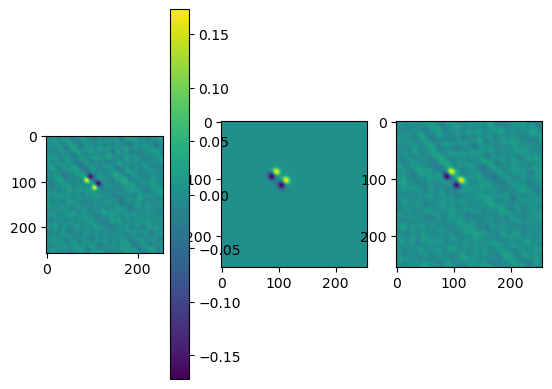

In [26]:
f_dark_abs = np.abs(f_dark)
f_angle = np.angle(f_dark)
f_light_abs = np.abs(f_light)
delta_f = (f_light_abs - f_dark_abs) 
beta = .01
delta_f_with_phase = delta_f * np.exp(1j * f_angle)
f_xtr = 2/beta*delta_f_with_phase+f_dark
dens_xtr = np.fft.ifft2(f_xtr).real
real_CC = pearsonr(dens_xtr.flatten(), delta_obj.flatten())[0]
fig, axs = plt.subplots(1,3)
ax = axs[0]
im =ax.imshow(obj1-dens_xtr)
plt.colorbar(im)
ax = axs[1]
ax.imshow(delta_obj)
ax = axs[2]
ax.imshow(np.fft.ifft2(delta_f_with_phase).real)
alpha2 = 0.3
mixed = (1-alpha2)*obj0+ alpha2*obj1
real_CC = pearsonr(dens_xtr.flatten(), obj0.flatten())[0]
real_CC

In [27]:
alpha = 0.3
noise_level = 0
obj1, obj0 =  make_objs(blur_by=blur_by)
f_dark, f_light, delta_fa_abs = make_working_vars(obj1, obj0, alpha, old_version=True)
alpha_xtrs_vis = np.array([0.01, 0.1, alpha/2, alpha, 2*alpha, .9])
f_xtrs_vis = make_f_xtr(alpha_xtrs_vis, f_dark, f_light, np.angle(f_dark),  version=1, noise_level = 0)
dens_xtrs_vis, _ = marius(f_xtrs_vis)
# dens_xtrs_vis = np.fft.fftn(f_xtrs_vis, axes=np.arange(1,f_xtrs_vis.ndim)).real
fig, axs = plt.subplots(2,3, figsize=(8,4),constrained_layout=True)
steps = 1
print(alpha_xtrs_vis)
for ax, alpha_xtr, arr in zip(axs.flat, alpha_xtrs_vis,dens_xtrs_vis):
    raw = [r"$\alpha_{xtr}$",
           r"$\alpha_t$"]
    tit = f"{raw[0]}: {alpha_xtr:.2f}"
    ax.set_title(tit)
    # diff = (arr-obj0)
    vmax = np.max(arr)
    im = ax.imshow(arr, cmap="bwr",vmin=-vmax, vmax=vmax)
    plt.colorbar(im)
plt.show()    


NameError: name 'blur_by' is not defined

In [ ]:
f_dark, f_light, delta_fa_abs = make_working_vars(obj1, obj0, alpha, old_version=False)
alpha_xtrs_vis = np.array([0.01, 0.1, alpha/2, alpha, 2*alpha, .9])
f_xtrs_vis = make_f_xtr(alpha_xtrs_vis, f_dark, f_light, np.angle(f_dark),  version=1, noise_level = 0)
dens_xtrs_vis, _ = marius(f_xtrs_vis)
# dens_xtrs_vis = np.fft.fftn(f_xtrs_vis, axes=np.arange(1,f_xtrs_vis.ndim)).real
fig, axs = plt.subplots(2,3, figsize=(8,4),constrained_layout=True)
steps = 1
for ax, alpha_xtr, arr in zip(axs.flat, alpha_xtrs_vis,dens_xtrs_vis):
    raw = [r"$\alpha_{xtr}$",
           r"$\alpha_t$"]
    tit = f"{raw[0]}: {alpha_xtr:.2f}"
    ax.set_title(tit)
    diff = (arr-alpha_xtr*obj0)
    diff = arr
    print(alpha_xtr,pearsonr(arr.flatten(),obj1.flatten()))
    vmax = np.max(diff)
    im = ax.imshow(diff, cmap="bwr",vmin=-vmax, vmax=vmax)
    plt.colorbar(im)
plt.show()    

In [ ]:
alpha_xtrs = np.linspace(5e-2,1,30 )
f_xtrs = make_f_xtr(alpha_xtrs, f_dark, f_light, np.angle(f_dark),  version=vvv, noise_level=0)
peak_sum, real_CC = x8_density_map(f_xtrs, mask_pks, obj0, delta_obj)
peak_sum4, real_CC4, real_CC2 = x8_density_map7(f_xtrs, mask_pks, obj0, delta_obj)
fig, axs = plt.subplots(2,2, figsize=(8,8),tight_layout=True)
for ax in axs[0] :
    ax.set_ylabel("Ratio prominent over all peaks")
    ax.set_title("Difference Map Method")
    
for ax in axs[:,0] :
    ax.axvline(1/alpha,c="k", linestyle="-.", label="alpha_true")
    ax.axvline(1/(alpha*2),c="k", linestyle="--", label="2*alpha_true")
    
for ax in axs[:,1] :
    ax.axvline(alpha,c="k", linestyle="-.", label="alpha_true")
    ax.axvline(alpha*2,c="k", linestyle="--", label="2*alpha_true")
    
for ax in axs[1] :
    ax.axhline(0,c="k", linewidth=.5, )
    ax.set_ylabel("Cross Correlation")
    ax.set_xlabel("Alphas")
    ax.set_title("Difference Map (CC) Method")

ax = axs[0,0]
ax.plot(1/alpha_xtrs,peak_sum, label=r"F_xtr",color="g")
ax.plot(1/alpha_xtrs,peak_sum4, label=r"F_xtr-F0",color="brown")
ax.legend()

ax = axs[0,1]
ax.plot(alpha_xtrs,peak_sum, label=r"$\phi_{0}$",color="g")
ax.plot(alpha_xtrs,peak_sum4, label=r"$\phi_{0}$",color="brown")

ax = axs[1,0]
ax.plot(1/alpha_xtrs,real_CC, label=r"$\phi_{0}$",color="g")
ax.plot(1/alpha_xtrs,real_CC4, label=r"$\phi_{0}$",color="brown")
# ax.plot(1/alpha_xtrs,real_CC2, label=r"$\phi_{0}$",color="blue")
ax.set_xlabel("1/occupancy")

ax = axs[1,1]
ax.plot(alpha_xtrs,real_CC,  label=r"F_xtr"    ,    color="g")
ax.plot(alpha_xtrs,real_CC4, label=r"F_xtr-F0",color="brown")
# ax.plot(alpha_xtrs,real_CC2, label=r"$\phi_{0}$",color="blue")
ax.set_xlabel("occupancy")



# Adding Noise

In [ ]:
blur_by = 2
alpha = 0.3
noise_level_one = 3
obj1, obj0 =  make_objs(blur_by=blur_by)
f_dark, f_light, delta_fa_abs = make_working_vars(obj1, obj0, alpha, old_version=False)


In [ ]:
alpha_xtrs = np.linspace(0,1,340)+1e-10
f_xtrs = make_f_xtr(alpha_xtrs, f_dark, f_light, np.angle(f_dark),  version=1, noise_level = noise_level_one)
corr_x8 = x8_inspired(np.abs(f_dark),np.abs(f_light), np.abs(f_xtrs))

In [ ]:
fig, axs = plt.subplots(2, tight_layout=True)
ax = axs[0]
ax.plot(alpha_xtrs,corr_x8, label="CC($|F_{light}|-|F_{dark}|, |F_{extr}| - |F_{dark}|$)")
ax.axhline(0,c="k", linewidth=.5, )
ax.axvline(alpha,c="k", linestyle="-.", label="alpha_true")
ax.axvline(2*alpha,c="k", linestyle="--", label="2alpha_true")
ax.legend()
ax.set_ylabel("Cross Correlation")
ax.set_title("Cross Correlation Fourier Space")
ax = axs[1]

ax.plot(alpha_xtrs,np.gradient(corr_x8), label="CC($|F_{light}|-|F_{dark}|, |F_{extr}| - |F_{dark}|$)")
ax.axvline(alpha,c="k", linestyle="-.", label="alpha_true")
ax.axvline(2*alpha,c="k", linestyle="--", label="2alpha_true")
# ax.axvline(alpha/2,c="k", linestyle="-.", label="True alpha/2")
# ax.legend()
ax.set_xlabel("Alpha")
ax.set_ylabel("Gradient of CC")

In [ ]:
levels = [0,0.05,0.1, 0.25, 0.5, 1, 2, 3, 5]
alpha_xtrs = np.linspace(0,1,500)+1e-10
alpha_max = np.empty(len(levels))
alpha_closest = np.empty(len(levels))
for ii, noise_level in enumerate(levels):
    f_xtrs = make_f_xtr(alpha_xtrs, f_dark, f_light, np.angle(f_dark),  version=1, noise_level = noise_level)
    corr_x8 = x8_inspired(np.abs(f_dark),np.abs(f_light), np.abs(f_xtrs))
    max_idx = np.argmax(np.gradient(corr_x8))
    closest_index = min(range(len(corr_x8)), key=lambda i: abs(corr_x8[i]))
    alpha_max[ii] = alpha_xtrs[max_idx]
    alpha_closest[ii] = alpha_xtrs[closest_index]

plt.figure()
ax =plt.gca()
ax.plot(levels, alpha_max, "x", alpha=0.5, label="Peak Gradient")
ax.plot(levels, alpha_closest, "x", alpha=0.5, label = "Zero Crossing")
ax.legend()
ax.set_ylabel("Optimal alpha")
ax.set_xlabel("Noise Level (relative to mean intensity)")



In [ ]:
alpha_invs = (np.arange(0,20)+1e-10)
alpha_xtrs = 2/alpha_invs
alpha_xtrs = np.array([0.01, 0.1, alpha/2, alpha, 2*alpha, 1])
from occupancy import marius
f_xtrs = make_f_xtr(alpha_xtrs, f_dark, f_light, np.angle(f_light),  version=1, noise_level = 3)
dens_xtrs, neg_sum = marius(f_xtrs)

In [ ]:
fig, axs = plt.subplots(2,3, figsize=(8,4),constrained_layout=True)
steps = len(alpha_xtrs)//6
for ax, alpha_xtr, arr in zip(axs.flat, alpha_xtrs[::steps],dens_xtrs[::steps]):
    raw = [r"$\alpha_{xtr}$",
           r"$\alpha_t$"]
    tit = f"{raw[0]}: {alpha_xtr:.2f}, {raw[1]}: {alpha:.2f}"
    ax.set_title(tit)
    
    im = ax.imshow((arr), cmap="bwr",vmin=-np.max(arr))
    plt.colorbar(im)
plt.show()    


In [ ]:
from scipy import stats
n_largest = 4
m1 = alpha_invs>alpha_invs[-n_largest]
m2 = alpha_invs<alpha_invs[n_largest]
res_1 = stats.linregress(alpha_invs[m1], -neg_sum[m1])
res_2 = stats.linregress(alpha_invs[m2], -neg_sum[m2])
# res_11 = stats.linregress(alpha_invs[m11], -neg_sum[m11])
# res_22 = stats.linregress(alpha_invs[m22], -neg_sum[m22])

alpha_line = np.linspace(np.min(alpha_invs), np.max(alpha_invs),5,)

plt.plot(alpha_invs,neg_sum*-1, "x",  label="Datapoint")
plt.axvline(1/alpha,c="k",linestyle="--", label="1/alpha_true")
plt.axvline(2/alpha,c="k",linestyle="-.", label="2/alpha_true")


plt.plot(alpha_line, res_1.intercept+res_1.slope*alpha_line,c="red",linestyle="--", label=f"Fit (largest {n_largest})")
plt.plot(alpha_line, res_2.intercept+res_2.slope*alpha_line, c="darkgreen",linestyle="--",label=f"Fit (smallest {n_largest})")
# plt.plot(alpha_line, res_11.intercept+res_11.slope*alpha_line,c="purple",linestyle="--", label="Fit (all larger )")
plt.legend()
# plt.plot(alpha_line, res_22.intercept+res_22.slope*alpha_line, c="purple",linestyle="--")
plt.xlabel("2/Alpha")
plt.ylabel(r"$\sum$ |neg. density|")
plt.title("'Marius Method'")
plt.savefig("mariusmethod.png")

In [ ]:
def get_intersect_and_angle(alpha_invs, neg_sum):
    n_largest = 4
    m1 = alpha_invs>alpha_invs[-n_largest]
    m2 = alpha_invs<alpha_invs[n_largest]
    res_1 = stats.linregress(alpha_invs[m1], -neg_sum[m1])
    res_2 = stats.linregress(alpha_invs[m2], -neg_sum[m2])
    print(res_1.slope,  res_2.slope)
    intersection = (res_2.intercept-res_1.intercept) / (res_1.slope-res_2.slope)
    
    angle_raw = (res_1.slope-res_2.slope) / (1 + res_1.slope*res_2.slope)
    angle = np.degrees(np.arctan(np.abs(angle_raw)))
    return intersection, angle


angles = np.empty(len(levels))
intersections = np.empty(len(levels))
alpha_invs = (np.arange(0,20)+1e-10)
alpha_xtrs = 2/alpha_invs
for ii, noise_level in enumerate(levels):
    f_xtrs = make_f_xtr(alpha_xtrs, f_dark, f_light, np.angle(f_light),  version=1, noise_level = noise_level)
    dens_xtrs, neg_sum = marius(f_xtrs)
    intersections[ii],angles[ii] = get_intersect_and_angle(alpha_invs, neg_sum)
   

In [ ]:
np.degrees(np.arctan(np.abs((+18-1.3)/ (1 -18*1.3))))

In [ ]:
 
plt.plot(levels, 2/intersections, "x")
plt.show()
plt.plot(levels, angles, "x")
plt.xlabel("Noise Level")
plt.ylabel("Slope Angle (Deg)")

In [ ]:
plt.imshow(mask_pks)                            

In [ ]:
from occupancy import x8_density_map
noise_level = 1
delta_obj = alpha*(obj1-obj0)
mask_pks = np.abs(delta_obj)>0.01
f_mix = np.fft.fft2(delta_obj)
true_phase = np.angle(f_mix)
rand_phase = np.random.uniform(size=true_phase.shape)*2*np.pi

alpha_xtrs = np.linspace(1e-3,2,150 )
f_xtrs = make_f_xtr(alpha_xtrs, f_dark, f_light, np.angle(f_dark),  version=1, noise_level=noise_level)
f_xtrs_opt = make_f_xtr(alpha_xtrs, f_dark, f_light, true_phase,  version=1, noise_level=noise_level)
f_xtrs_rand = make_f_xtr(alpha_xtrs, f_dark, f_light, rand_phase,  version=1, noise_level=noise_level)
peak_sum, real_CC = x8_density_map(f_xtrs, mask_pks, obj0)
peak_sum_opt, real_CC_opt = x8_density_map(f_xtrs_opt, mask_pks, obj0)
peak_sum_rand, real_CC_rand = x8_density_map(f_xtrs_rand, mask_pks, obj0)

In [ ]:
print(noise_level)
plt.figure()
ax = plt.gca()
ax.axvline(alpha,c="k", linestyle="-.", label="alpha_true")
ax.axvline(alpha*2,c="k", linestyle="--", label="2*alpha_true")
# ax.axvline(alpha/2,c="k", linestyle="-.", label="True alpha/2")
ax.plot(alpha_xtrs,peak_sum, label=r"$\phi_{0}$",color="g")

# ax.plot(alpha_xtrs,peak_sum_opt, label=r"$\phi_{opt}$",color="blue")
# ax.plot(alpha_xtrs,peak_sum_rand, label=r"$\phi_{rand}$",color="grey")
print(alpha_xtrs[np.argmin(peak_sum)])
print(alpha_xtrs[np.argmin(peak_sum_opt)])
ax.set_ylabel("Ratio prominent over all peaks")
ax.set_xlabel("Alphas")
ax.legend(loc="lower right")
ax.set_title("Difference Map Method")

In [ ]:
plt.figure()
ax = plt.gca()
ax.axvline(alpha,c="k", linestyle="-.", label="alpha_true")
ax.axvline(alpha*2,c="k", linestyle="--", label="2*alpha_true")
ax.axhline(0,c="k", linewidth=.5, )
ax.plot(alpha_xtrs,real_CC, label=r"$\phi_{0}$",color="g")
ax.plot(alpha_xtrs,real_CC_opt, label=r"$\phi_{opt}$",color="blue")
ax.plot(alpha_xtrs,real_CC_rand, label=r"$\phi_{rand}$",color="grey")
ax.set_ylabel("Cross Correlation")
ax.set_xlabel("Alphas")
ax.legend(loc="lower right")
ax.set_title("Difference Map (CC) Method")


In [ ]:
plt.figure()
ax = plt.gca()
ax.axvline(alpha,c="k", linestyle="-.", label="alpha_true")
ax.axvline(alpha*2,c="k", linestyle="--", label="2*alpha_true")
ax.axhline(0,c="k", linewidth=.5, )
ax.plot(alpha_xtrs,np.gradient(real_CC), label=r"$\phi_{0}$",color="g")
ax.plot(alpha_xtrs,np.gradient(real_CC_opt), label=r"$\phi_{opt}$",color="blue")
ax.set_ylabel("Cross Correlation")
ax.set_xlabel("Alphas")
ax.legend(loc="lower right")
ax.set_title("Difference Map (CC) Method")


In [ ]:

alpha_peak = np.empty(len(levels))
alpha_CC = np.empty(len(levels))
alpha_grad = np.empty(len(levels))
alpha_invs = (np.arange(0,20)+1e-10)
alpha_xtrs = 2/alpha_invs
for ii, noise_level in enumerate(levels):
   
    alpha_xtrs = np.linspace(1e-3,2,150 )
    f_xtrs = make_f_xtr(alpha_xtrs, f_dark, f_light, np.angle(f_light),  version=1, noise_level=noise_level)
    peak_sum, real_CC = x8_density_map(f_xtrs, mask_pks, obj0)
    peak_min = np.argmin(peak_sum)
    grad_min = min(range(len(real_CC)), key=lambda i: abs(real_CC[i]))
    CC_min = np.argmax(np.gradient(real_CC))
    alpha_peak[ii]= alpha_xtrs[peak_min]
    alpha_CC[ii]= alpha_xtrs[CC_min]
    alpha_grad[ii]= alpha_xtrs[grad_min]
    
plt.figure()
ax =plt.gca()
ax.plot(levels, alpha_CC, "x", alpha=0.5, label="Zero Crossing (CC)")
ax.plot(levels, alpha_peak, "x", alpha=0.5, label = "Minimum Peak Ratio")
ax.plot(levels, alpha_grad, "x", alpha=0.5, label = "Peak Gradient (CC)")
ax.legend()
ax.set_ylabel("Optimal alpha")
ax.set_xlabel("Noise Level (relative to mean intensity)")



In [ ]:
alpha_xtrs = np.linspace(1e-3,2,150 )
noise_level=3
f_xtrs = make_f_xtr(alpha_xtrs, f_dark, f_light, np.angle(f_dark),  version=1, noise_level=noise_level)
mean_local, mean_global = pandda(f_dark, f_xtrs, mask_pks)
fig, axs = plt.subplots(2)
ax = axs[0]
ax.axvline(alpha,c="k", linestyle="-.", label="alpha_true")
ax.axvline(alpha*2,c="k", linestyle="--", label="2*alpha_true")
ax.plot(alpha_xtrs,+mean_global-mean_local, label="global-local") 
ax.legend()
ax.set_title("PanDDA method")
ax = axs[1]
ax.axvline(alpha,c="k", linestyle="-.", label="alpha_true")
ax.axvline(alpha*2,c="k", linestyle="--", label="2*alpha_true")
ax.plot(alpha_xtrs,mean_local, label="local") 
ax.plot(alpha_xtrs, mean_global,label="global")
ax.legend()
# ax = axs[2]
# ax.axvline(alpha,c="k", linestyle="-.", label="alpha_true")
# ax.axvline(alpha*2,c="k", linestyle="--", label="2*alpha_true")
# ax.plot(alpha_xtrs,+np.gradient(mean_global-mean_local), label="global-local") 
# ax.legend()
# print(alpha_xtrs[np.argmax(mean_global-mean_local)])

In [ ]:
alpha_pandda = np.empty(len(levels))

alpha_xtrs = np.linspace(1e-3,2,150 )
for ii, noise_level in enumerate(levels):
   
    f_xtrs = make_f_xtr(alpha_xtrs, f_dark, f_light, np.angle(f_light),  version=1, noise_level=noise_level)
    mean_local, mean_global = pandda(f_dark, f_xtrs, mask_pks)
    mean_diff = np.gradient(mean_global-mean_local)
    closest_index = min(range(len(mean_diff)), key=lambda i: abs(mean_diff[i]))
    idx_pandda = np.argmax(mean_global-mean_local)
    alpha_pandda[ii]= alpha_xtrs[idx_pandda]
   

In [ ]:
 
plt.figure()
ax =plt.gca()
# ax.plot(levels, alpha_pandda, "x", alpha=0.5, label="Pandda (Max value)")
ax.plot(levels, alpha_CC, "x", alpha=0.5, label="Difference Map (Zero Crossing - CC)")
ax.plot(levels, alpha_grad, "x", alpha=0.5, label = "Difference Map (Peak Gradient - CC)")
ax.plot(levels, alpha_peak, "x", alpha=0.5, label = "Difference Map (Minimum of Peak Ratio) ")
ax.plot(levels, 2/intersections, "x", label="Intersection point (Marius)")
ax.axhline(2*alpha, linestyle="--", color='k',label="2*alpha_true")

ax.legend()
ax.set_ylabel("Optimal alpha")
ax.set_xlabel("Noise Level (relative to mean intensity)")